In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Establish plotting order
drug_list = [
    'ISONIAZID',
    'RIFAMPICIN',
    'ETHAMBUTOL',
    'PYRAZINAMIDE',
    'STREPTOMYCIN', 
    'AMIKACIN',
    'CAPREOMYCIN',
    'KANAMYCIN',
    'CIPROFLOXACIN',
    'OFLOXACIN',
    'MOXIFLOXACIN', 
    'LEVOFLOXACIN',
]

model_order = [
    "Reg+L2",
    "WDNN",
    "MD-CNN",
    "SD-CNN"
]

# Change phenotype data to 0s and 1s
def rs_encoding_to_numeric(df_geno_pheno, drugs_list):
    """
	Creates a matrix of y values (resistance/sensitivity)
	to each drug, encoded as 0's and 1's
	Parameters
	----------
	df_geno_pheno: pd.DataFrame


	Returns
	-------
	pd.Dataframe

    np.ndarray

	"""
    y_all_rs = df_geno_pheno[drugs_list]
    y_all_rs = y_all_rs.fillna('-1')
    y_all_rs = y_all_rs.astype(str)
    resistance_categories = {'R': 0, 'S': 1, '-1.0': -1, '-1': -1}

    y_all = y_all_rs.copy()
    for key, val in resistance_categories.items():
        y_all[y_all_rs == key] = val

    y_all.index = list(range(0, y_all.shape[0]))

    return y_all

## Selecting an MD-CNN architecture

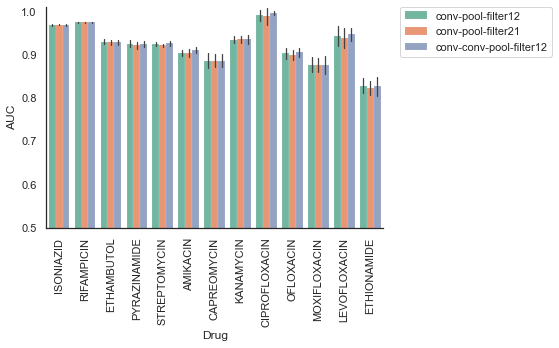

In [20]:
### Comparing the three  MD-CNN models

# Establish a color scheme
colors=[
    "#00b3ca",
    "#9dc6d8",
    "#e38690",
]

sns.set(rc={"lines.linewidth": 0.7})
sns.set_style("white")
sns.set_palette("Set2")

## Read in the cross validation AUC for each of the three models
example_21 = pd.read_csv('results_20210201_filter21_epochs200/20210201_filter21_epochs200_auc.csv')
example_21['model'] = 'conv-pool-filter21'
example_12 = pd.read_csv('results_20210203_filter12_epoch200/results_20210203_filter12_epoch200_auc.csv')
example_12['model'] = 'conv-pool-filter12'
example_ccp = pd.read_csv('results_20210201_ccp_filter12_epoch150/results_20210201_ccp_filter12_epoch150_auc.csv')
example_ccp['model'] = 'conv-conv-pool-filter12'

# Concatenate
x = pd.concat([
    example_12, 
    example_21,
    example_ccp,
])

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(drug_list, range(len(drug_list))))
modelSorterIndex = dict(zip(model_order, range(len(model_order))))

# Generate a rank column that will be used to sort
# the dataframe numerically
modelSorterIndex = dict(zip(['conv-pool-filter12', 'conv-pool-filter21', 'conv-conv-pool-filter12'], 
                            range(len(['conv-pool-filter12', 'conv-pool-filter21', 'conv-conv-pool-filter12']))))
x['rank'] = x['Drug'].map(sorterIndex)
x['model_rank']= x['model'].map(modelSorterIndex)
x = x.sort_values(["rank", "model_rank"])
x["Drug_set"] = [f"{drug}_{model}" for drug, model in zip(x.Drug, x.model)]

# Plot
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.barplot(data=x, x="Drug", y="AUC", hue="model", ax=ax, linewidth=0.1, ci="sd")
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0.5,1.01])
plt.xticks(rotation = 90)
plt.tight_layout()
#plt.show()
plt.savefig("MD-CNN_architecture_AUC_comparison_zoomed.pdf")

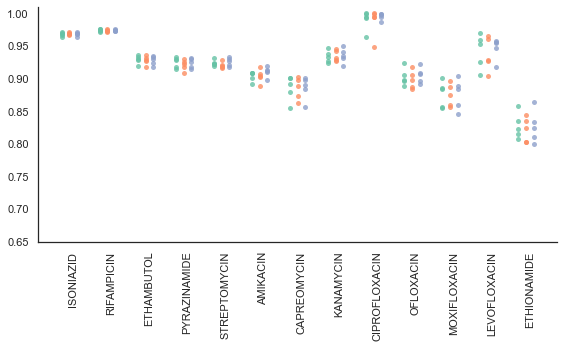

In [21]:
modelSorterIndex = dict(zip(['conv-pool-filter12', 'conv-pool-filter21', 'conv-conv-pool-filter12'], 
                            range(len(['conv-pool-filter12', 'conv-pool-filter21', 'conv-conv-pool-filter12']))))
x['rank'] = x['Drug'].map(sorterIndex)
x['model_rank']= x['model'].map(modelSorterIndex)
x = x.sort_values(["rank", "model_rank"])
x["Drug_set"] = [f"{drug}_{model}" for drug, model in zip(x.Drug, x.model)]

# thirteen drugs, 50 drug-model combos (ie, 2 missing)
drug_list = [
    'ISONIAZID',
    'RIFAMPICIN',
    'ETHAMBUTOL',
    'PYRAZINAMIDE',
    'STREPTOMYCIN', 
    'AMIKACIN',
    'CAPREOMYCIN',
    'KANAMYCIN',
    'CIPROFLOXACIN',
    'OFLOXACIN',
    'MOXIFLOXACIN', 
    'LEVOFLOXACIN',
    'ETHIONAMIDE'
]
sns.set_palette("Set2", 3)
# Plot
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.set_ylim([0.65,1.01])

# Plots the complete data points
current_x = 0
current_drug = list(x.Drug)[0]
for drug_set in list(x.Drug_set.unique()):

    subset = x.query("Drug_set==@drug_set")
    drug = list(subset.Drug)[0]
    #print(drug)
    if drug != current_drug:
        current_x += 2
        current_drug = drug
    

    ax.scatter([current_x]*len(subset.AUC), subset.AUC, alpha = 0.8, linewidth=0, s=25)

    current_x += 1

sns.despine()

ticks = np.arange(1, 62, 5, dtype=float) + 0.5
plt.xticks(ticks=ticks, labels=drug_list, rotation=90)
plt.tight_layout()
plt.savefig("allmodel_AUC_comparison_zoomed_dots.pdf")

plt.show()

## Comparing models on training set cross validation

In [6]:
## Collate the Regression + L2 results
xval_l2_data = pd.DataFrame()
for file in glob.glob("20210611_L2_regression/*/XVal_accuracy.csv"):
    _d = pd.read_csv(file, index_col=0)
    drug = file.split("/")[1]
    _d["Drug"] = drug
    xval_l2_data = pd.concat([xval_l2_data, _d])
xval_l2_data.to_csv("20210611_L2_regression/combined_XVal_accuracy.csv")
xval_l2_data.drug.unique()

array(['STREPTOMYCIN', 'KANAMYCIN', 'MOXIFLOXACIN', 'AMIKACIN',
       'RIFAMPICIN', 'CIPROFLOXACIN', 'ETHIONAMIDE', 'LEVOFLOXACIN',
       'CAPREOMYCIN', 'PYRAZINAMIDE', 'OFLOXACIN', 'ETHAMBUTOL',
       'ISONIAZID'], dtype=object)

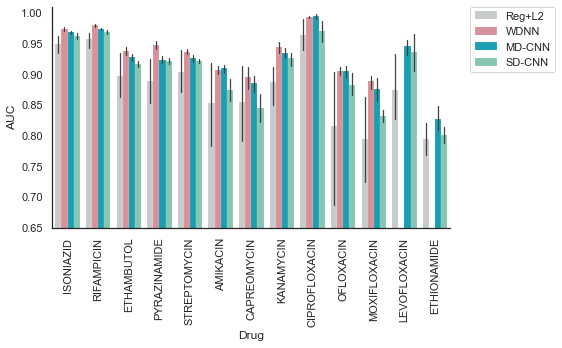

In [7]:
## Comparing the MD-CNN, SD-CNN, L@, and WDNN performance on cross-validation set
colors=[
        "#c6cccc","#e38690",
     "#00b3ca","#7dd0b6"
]
sns.set_palette(sns.color_palette(colors))
sns.set(rc={"lines.linewidth": 0.7})
sns.set_style("white")

# Read in the Xval AUC for each model
example_ccp = pd.read_csv('results_20210201_ccp_filter12_epoch150/results_20210201_ccp_filter12_epoch150_auc.csv')
example_ccp['model'] = 'MD-CNN'
example_l2 = pd.read_csv('20210611_L2_regression/combined_XVal_accuracy.csv')
example_l2["model"] = "Reg+L2"
singletasks = pd.read_csv("../singletasks/singletask_model_auc.csv")
singletasks["model"] = "SD-CNN"
wdnn = pd.read_csv("results_cv_wdnn_091719/wdnn_cv_070720_threshold_round1.csv")
wdnn['model'] = 'WDNN'

# Concatenate into single df
x = pd.concat([
    example_l2, wdnn, 
    example_ccp, singletasks
])

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(drug_list, range(len(drug_list))))
modelSorterIndex = dict(zip(model_order, range(len(model_order))))

# Generate a rank column that will be used to sort
# the dataframe numerically
x['rank'] = x['Drug'].map(sorterIndex)
x['model_rank']= x['model'].map(modelSorterIndex)
x = x.sort_values(["rank", "model_rank"])

sns.set_palette(sns.color_palette(colors))

# Plot
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.barplot(data=x, x="Drug", y="AUC", hue="model", ax=ax, linewidth=0.1)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0.65,1.01])
plt.xticks(rotation = 90)
plt.tight_layout()
#plt.show()
plt.savefig("allmodel_AUC_comparison_zoomed_0p7.pdf")

x.to_csv("model_comparison_output.csv")

(-0.5, 49.5)

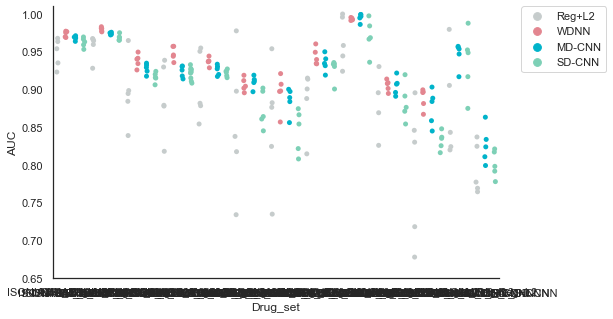

In [8]:
## Comparing the MD-CNN, SD-CNN, L@, and WDNN performance on cross-validation set
colors=[
        "#c6cccc","#e38690",
     "#00b3ca","#7dd0b6"
]
sns.set_palette(sns.color_palette(colors))
sns.set(rc={"lines.linewidth": 0.7})
sns.set_style("white")

# Read in the Xval AUC for each model
example_ccp = pd.read_csv('results_20210201_ccp_filter12_epoch150/results_20210201_ccp_filter12_epoch150_auc.csv')
example_ccp['model'] = 'MD-CNN'
example_l2 = pd.read_csv('20210611_L2_regression/combined_XVal_accuracy.csv')
example_l2["model"] = "Reg+L2"
singletasks = pd.read_csv("../singletasks/singletask_model_auc.csv")
singletasks["model"] = "SD-CNN"
wdnn = pd.read_csv("results_cv_wdnn_091719/wdnn_cv_070720_threshold_round1.csv")
wdnn['model'] = 'WDNN'

# Concatenate into single df
x = pd.concat([
    example_l2, wdnn, 
    example_ccp, singletasks
])

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(drug_list, range(len(drug_list))))
modelSorterIndex = dict(zip(model_order, range(len(model_order))))

# Generate a rank column that will be used to sort
# the dataframe numerically
x['rank'] = x['Drug'].map(sorterIndex)
x['model_rank']= x['model'].map(modelSorterIndex)
x = x.sort_values(["rank", "model_rank"])
x["Drug_set"] = [f"{drug}_{model}" for drug, model in zip(x.Drug, x.model)]
sns.set_palette(sns.color_palette(colors))

# Plot
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.stripplot(data=x, x="Drug_set", y="AUC", hue="model", ax=ax, jitter=True)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0.65,1.01])

ax.get_xlim()
# plt.xticks(labels = drug_list, rotation = 90)
# plt.tight_layout()
# #plt.show()
# plt.savefig("allmodel_AUC_comparison_zoomed_0p7.pdf")

# x.to_csv("model_comparison_output.csv")

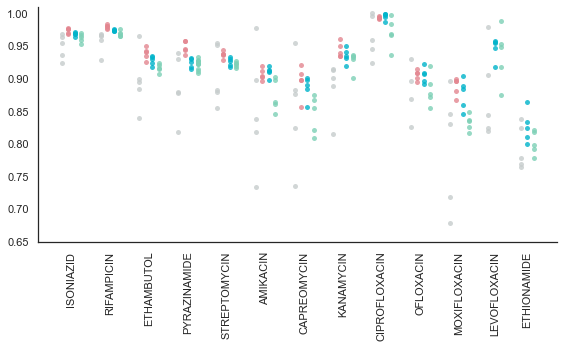

In [12]:
# thirteen drugs, 50 drug-model combos (ie, 2 missing)
drug_list = [
    'ISONIAZID',
    'RIFAMPICIN',
    'ETHAMBUTOL',
    'PYRAZINAMIDE',
    'STREPTOMYCIN', 
    'AMIKACIN',
    'CAPREOMYCIN',
    'KANAMYCIN',
    'CIPROFLOXACIN',
    'OFLOXACIN',
    'MOXIFLOXACIN', 
    'LEVOFLOXACIN',
    'ETHIONAMIDE'
]
model_to_color={
    "Reg+L2":"#c6cccc",
    "WDNN":"#e38690",
    "MD-CNN":"#00b3ca",
    "SD-CNN":"#7dd0b6"
}

# Plot
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.set_ylim([0.65,1.01])

# Plots the complete data points
current_x = 0
current_drug = list(x.Drug)[0]
for drug_set in list(x.Drug_set.unique()):
    
    subset = x.query("Drug_set==@drug_set")
    drug = list(subset.Drug)[0]
    #print(drug)
    if drug != current_drug:
        current_x += 2
        current_drug = drug
    
    color = model_to_color[list(subset.model)[0]]
    
    ax.scatter([current_x]*len(subset.AUC), subset.AUC, alpha = 0.8, color=color, linewidth=0, s=25)
    #ax.scatter(current_x, subset.AUC.mean(), alpha = 1, color="dimgrey", linewidth=2, marker="_")
    
    current_x += 1

sns.despine()

ticks = np.arange(1, 74, 6, dtype=float) + 0.5
ticks[-2] = ticks[-2] -.5
ticks[-1] = 72
plt.xticks(ticks=ticks, labels=drug_list, rotation=90)
plt.tight_layout()
plt.savefig("allmodel_AUC_comparison_zoomed_dots.pdf")
plt.show()

## More interpretable plot


In [7]:
first_line_mtcnn = x.query("model=='MD-CNN'")
print("Mean AUC, MD-CNN", first_line_mtcnn.AUC.mean())

first_line_wdnn = x.query("model=='WDNN'")
print("Mean AUC, WDNN", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='Reg+L2' ")
print("Mean AUC, Reg+L2", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='SD-CNN'")
print("Mean AUC, SD-CNN", first_line_wdnn.AUC.mean())

Mean AUC, MD-CNN 0.9229513011204676
Mean AUC, WDNN 0.9372341599852709
Mean AUC, Reg+L2 0.8794205067562131
Mean AUC, SD-CNN 0.9058076696828532


In [54]:
def ci(values, z=1.96):
    mean = np.mean(values)
    s = np.std(values)
    n = len(values)
    
    ci_lower = mean - z * (s / np.sqrt(n))
    
    ci_upper = mean + z * (s / np.sqrt(n))
    return ci_lower, ci_upper


<ipython-input-55-2292719bb9aa>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + labels)


1 SD-CNN
2 MD-CNN
3 WDNN
4 Reg+L2
5 SD-CNN
6 MD-CNN
7 WDNN
8 Reg+L2


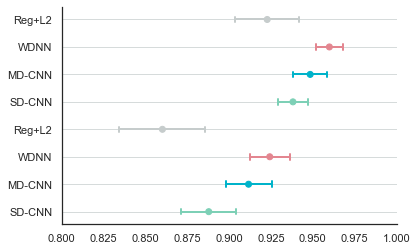

In [55]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
model_order = [
    "Reg+L2",
    "WDNN",
    "MD-CNN",
    "SD-CNN"
]

first_line_data = x.query("Drug in @first_line")
second_line_data = x.query("not Drug in @first_line")

first_line_means = first_line_data.groupby("model").mean().sort_values("model_rank", ascending=False).AUC

second_line_means = second_line_data.groupby("model").mean().sort_values("model_rank", ascending=False).AUC

labels = list(second_line_means.index) + list(first_line_means.index) 

figure = plt.figure()
ax = figure.gca()

input_colors = colors+colors
input_colors.reverse()

ax.scatter(np.concatenate([second_line_means.values, first_line_means.values]), np.arange(1,9), color=input_colors)

ax.set_yticklabels([""] + labels)

for i in np.arange(1,9):
    ax.axhline(i)
 
# CIs for second line drugs
for i in np.arange(1,5):
    
    model = model_order[3 - (i-1)]
    print(i, model)
    
    current_color = colors[3 - (i-1)]
    ci_lower, ci_upper = ci(second_line_data.query("model==@model").AUC.values)
    ax.plot([ci_lower, ci_lower], [i-0.1, i+0.1], linewidth=2, color=current_color)
    ax.plot([ci_upper, ci_upper], [i-0.1, i+0.1], linewidth=2, color=current_color)
    ax.plot([ci_lower, ci_upper], [i,i], linewidth=2, color=current_color)

#CIs for first line drugs
for i in np.arange(5,9):
    
    model = model_order[3 - (i-1)]
    print(i, model)
    current_color = colors[3 - (i-5)]
    ci_lower, ci_upper = ci(first_line_data.query("model==@model").AUC.values)
    ax.plot([ci_lower, ci_lower], [i-0.1, i+0.1], linewidth=2, color=current_color)
    ax.plot([ci_upper, ci_upper], [i-0.1, i+0.1], linewidth=2, color=current_color)
    ax.plot([ci_lower, ci_upper], [i,i], linewidth=2, color=current_color)

ax.set_xlim([.8, 1])

sns.despine()
plt.savefig("first_v_second_line_breakdown.pdf")

In [62]:
second_line_means = second_line_data.groupby("model").mean().sort_values("model_rank", ascending=False).AUC
second_line_means

model
SD-CNN    0.887844
MD-CNN    0.911627
WDNN      0.924282
Reg+L2    0.860160
Name: AUC, dtype: float64

In [66]:
second_line_means = second_line_data.query("Drug != 'ETHIONAMIDE' and Drug != 'CIPROFLOXACIN'").groupby("model").mean().sort_values("model_rank", ascending=False).AUC
second_line_means

model
SD-CNN    0.888378
MD-CNN    0.911861
WDNN      0.912782
Reg+L2    0.854610
Name: AUC, dtype: float64

In [35]:
def ci_abs(values, z=1.96):
    mean = np.mean(values)
    s = np.std(values)
    n = len(values)

    return z * (s / np.sqrt(n))

logreg_cis = []
sdcnn_cis = []

for drug in drug_list:
    ci = ci_abs(x.query("model=='Reg+L2' and Drug==@drug").AUC.values)
    logreg_cis.append(ci)
    
    ci2 = ci_abs(x.query("model=='SD-CNN' and Drug==@drug").AUC.values)
    sdcnn_cis.append(ci2)
    


In [38]:
# Mean AUC for models

first_line_mtcnn = x.query("model=='MD-CNN' ")
print("Mean AUC, MD-CNN", first_line_mtcnn.AUC.mean())

first_line_wdnn = x.query("model=='WDNN'")
print("Mean AUC, WDNN", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='Reg+L2' ")
print("Mean AUC, Reg+L2", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='SD-CNN'")
print("Mean AUC, SD-CNN", first_line_wdnn.AUC.mean())

Mean AUC, MD-CNN 0.9229513011204676
Mean AUC, WDNN 0.9372341599852709
Mean AUC, Reg+L2 0.8794205067562131
Mean AUC, SD-CNN 0.9058076696828532


In [39]:
# Mean AUC for first-line drugs

first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_mtcnn = x.query("model=='MD-CNN' and Drug in @first_line")
print("Mean first line AUC, MD-CNN", first_line_mtcnn.AUC.mean())

first_line_wdnn = x.query("model=='WDNN' and Drug in @first_line")
print("Mean first line AUC, WDNN", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='Reg+L2' and Drug in @first_line")
print("Mean first line AUC, Reg+L2", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='SD-CNN' and Drug in @first_line")
print("Mean first line AUC, SD-CNN", first_line_wdnn.AUC.mean())

Mean first line AUC, MD-CNN 0.9484309864631424
Mean first line AUC, WDNN 0.9599008957405555
Mean first line AUC, Reg+L2 0.9227566743404922
Mean first line AUC, SD-CNN 0.9381425692353895


In [67]:
## Mean AUC for second line drugs
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_mtcnn = x.query("model=='MD-CNN' and not Drug in @first_line")
print("Mean second line AUC, MD-CNN", first_line_mtcnn.AUC.mean())

first_line_wdnn = x.query("model=='WDNN' and not Drug in @first_line")
print("Mean second line AUC, WDNN", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='Reg+L2' and not Drug in @first_line")
print("Mean second line AUC, Reg+L2", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='SD-CNN' and not Drug in @first_line")
print("Mean second line AUC, STCNN", first_line_wdnn.AUC.mean())

Mean second line AUC, MD-CNN 0.9116269965237233
Mean second line AUC, WDNN 0.9242817395536798
Mean second line AUC, Reg+L2 0.8601599878298667
Mean second line AUC, STCNN 0.8878438365981108


In [69]:
first_line_mtcnn.Drug.unique()

array(['STREPTOMYCIN', 'AMIKACIN', 'CAPREOMYCIN', 'KANAMYCIN',
       'CIPROFLOXACIN', 'OFLOXACIN', 'MOXIFLOXACIN', 'LEVOFLOXACIN',
       'ETHIONAMIDE'], dtype=object)

## Test set evaluation

In [30]:
st_train = pd.read_csv("singletask_bootstrapped_auc_train.csv")
st_test = pd.read_csv("singletask_bootstrapped_auc_test.csv")
mt_train = pd.read_csv("multitask_bootstrapped_auc_train.csv")
mt_test = pd.read_csv("multitask_bootstrapped_auc_test.csv")

st_train["set"] = "SD-CNN_train"
st_test["set"] = "SD-CNN_test"
mt_train["set"] = "MD-CNN_train"
mt_test["set"] = "MD-CNN_test"

d = pd.concat([st_train, st_test, mt_train, mt_test])

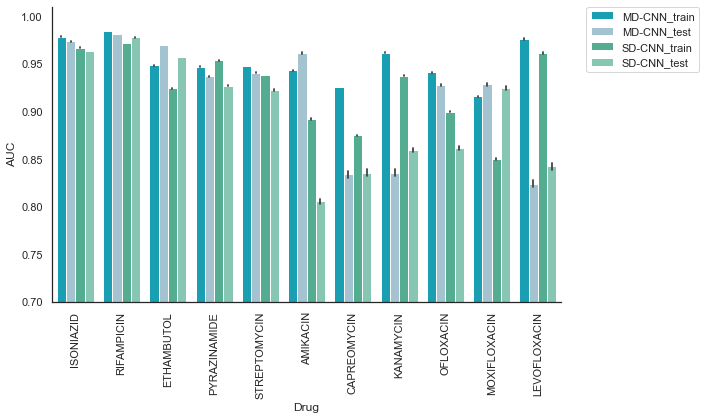

In [31]:
# Barplot of the AUC for BOOTSTRAPPED
colors=[
        "#00b3ca","#9dc6d8","#45bc96","#7dd0b6"
]
sns.set(rc={"lines.linewidth": 1})
sns.set_style("white")
sns.set_palette(sns.color_palette(colors))

figure = plt.figure(figsize=(10,6))
ax = figure.gca()

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(drug_list, range(len(drug_list))))
model_order = ["MD-CNN_train", "MD-CNN_test", "SD-CNN_train", "SD-CNN_test"]
modelSorterIndex = dict(zip(model_order, range(len(model_order))))


# Generate a rank column that will be used to sort
# the dataframe numerically
d['rank'] = d['Drug'].map(sorterIndex)
d['model_rank'] =d["set"].map(modelSorterIndex)
d = d.sort_values(["rank", "model_rank"])


sns.barplot(data=d, x="Drug", y="AUC", hue="set")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0.7,1.01])
sns.despine()
plt.xticks(rotation = 90)

plt.tight_layout()
plt.savefig("CNN_generalization.pdf")
plt.show()
d.to_csv("test_set_generalization.csv")

In [32]:
# # Barplot of the AUC for each
# colors=[
#         "#00b3ca","#9dc6d8","#45bc96","#7dd0b6"
# ]
# sns.set(rc={"lines.linewidth": 1})
# sns.set_style("white")
# sns.set_palette(sns.color_palette(colors))

# figure = plt.figure(figsize=(10,6))
# ax = figure.gca()

# # Create the dictionary that defines the order for sorting
# sorterIndex = dict(zip(drug_list, range(len(drug_list))))
# model_order = ["MD-CNN_train", "MD-CNN_test", "SD-CNN_train", "SD-CNN_test"]
# modelSorterIndex = dict(zip(model_order, range(len(model_order))))

# # Generate a rank column that will be used to sort
# # the dataframe numerically
# d['rank'] = d['Drug'].map(sorterIndex)
# d['model_rank'] =d["set"].map(modelSorterIndex)
# d = d.sort_values(["rank", "model_rank"])


# sns.barplot(data=d, x="Drug", y="AUC", hue="set", ci=None)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_ylim([0.7,1.01])
# sns.despine()
# plt.xticks(rotation = 90)

# plt.tight_layout()
# plt.savefig("CNN_generalization.pdf")
# plt.show()

<ipython-input-135-69911581131e>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + labels)


second line
1 SD-CNN_test 0.894482590208015 0.8295006889190547
2 SD-CNN_train 0.9029313673890453 0.8738248176186341
3 MD-CNN_test 0.9334510650613757 0.8520305351373687
4 MD-CNN_train 0.9584510761445272 0.9305802787530072
first line
5 SD-CNN_test 0.9742509981167137 0.9382939013583976
6 SD-CNN_train 0.9473198601358452 0.9289652783349338
7 MD-CNN_test 0.9821092672210664 0.9484678977015549
8 MD-CNN_train 0.9815941509941806 0.948090940800961


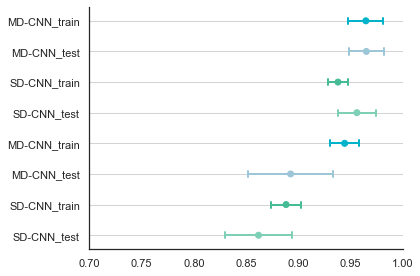

In [135]:
## SD-CNN test set performances

## This snippet reads the files from o2 and combines - no need to rerun
# path = "/Users/agreen/Beam_O2_mount/annachang/singletask_focus_v2/*tf1_model/*test_set_drug_auc.csv"
# sd_files = glob.glob(path)
# d = pd.DataFrame()
# for file in sd_files:
#     _d = pd.read_csv(file, index_col=0)
#     d = pd.concat([d, _d])
# d.to_csv("singletask_test_set_auc.csv")

singletask_test = pd.read_csv("singletask_test_set_auc.csv", index_col=0)
singletask_test['set'] = "SD-CNN_test"
singletasks = pd.read_csv("../singletasks/singletask_model_auc.csv")
singletasks['set'] = "SD-CNN_train"
singletasks= pd.concat([singletasks, singletask_test])

# MD-CNN test set performances

# Read in the test set accuracy
test = pd.read_csv("results_20210204_ccp_accuracy/results_20210204_ccp_accuracy_test_set_drug_auc.csv", index_col = 0)
test['set'] = 'MD-CNN_test'

# Read in the training set accuracy
train = pd.read_csv("results_20210204_ccp_accuracy/results_20210204_ccp_accuracy_training_set_drug_auc.csv", index_col = 0)
train['set'] = 'MD-CNN_train'

## Concatenate - NB We can't evaluate for CIPRO
d = pd.concat([train, test, singletasks])
d = d.query("Drug != 'CIPROFLOXACIN' and Drug != 'ETHIONAMIDE'")

d['rank'] = d['Drug'].map(sorterIndex)
d['model_rank'] =d["set"].map(modelSorterIndex)
d = d.sort_values(["rank", "model_rank"])

### Confidence interval calculation

def ci(values, z=1.96):
    mean = np.mean(values)
    s = np.std(values)
    n = len(values)
    
    ci_lower = mean - z * (s / np.sqrt(n))
    
    ci_upper = mean + z * (s / np.sqrt(n))
    return ci_lower, ci_upper


first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]

first_line_data = d.query("Drug in @first_line")
second_line_data = d.query("not Drug in @first_line")

first_line_means = first_line_data.groupby("set").mean().sort_values("model_rank", ascending=False).AUC

second_line_means = second_line_data.groupby("set").mean().sort_values("model_rank", ascending=False).AUC

labels = list(second_line_means.index) + list(first_line_means.index) 

figure = plt.figure()
ax = figure.gca()

input_colors = colors+colors
input_colors.reverse()

for i in np.arange(1,9):
    ax.axhline(i, color="lightgrey")

ax.scatter(np.concatenate([second_line_means.values, first_line_means.values]), np.arange(1,9), color=input_colors)

ax.set_yticklabels([""] + labels)

# CIs for second line drugs
print("second line")
for i in np.arange(1,5):

    model = model_order[3 - (i-1)]
    
    current_color = colors[3-(i-1)]
    ci_lower, ci_upper = ci(second_line_data.query("set==@model").AUC.values)
    print(i, model, ci_upper, ci_lower)
    ax.plot([ci_lower, ci_lower], [i-0.1, i+0.1], linewidth=2, color=current_color)
    ax.plot([ci_upper, ci_upper], [i-0.1, i+0.1], linewidth=2, color=current_color)
    ax.plot([ci_lower, ci_upper], [i,i], linewidth=2, color=current_color)

#CIs for first line drugs
print('first line')
for i in np.arange(5,9):
    
    model = model_order[3 - (i-1)]
   
    current_color = colors[3-(i-5)]
    ci_lower, ci_upper = ci(first_line_data.query("set==@model").AUC.values)
    print(i, model, ci_upper, ci_lower)
    ax.plot([ci_lower, ci_lower], [i-0.1, i+0.1], linewidth=2, color=current_color)
    ax.plot([ci_upper, ci_upper], [i-0.1, i+0.1], linewidth=2, color=current_color)
    ax.plot([ci_lower, ci_upper], [i,i], linewidth=2, color=current_color)

ax.set_xlim([.7, 1])

sns.despine()
plt.tight_layout()
plt.savefig("TEST_first_v_second_line_breakdown.pdf")

In [38]:
second_line_data.query("set==@model").AUC.values

array([0.92268691, 0.79433033, 0.83170424, 0.85791121, 0.86125302,
       0.924159  , 0.84189676])

In [ ]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_train = d.query("set=='MD-CNN_train' and Drug in @first_line")
print("Mean first line MD-CNN AUC, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='MD-CNN_test' and Drug in @first_line")
print("Mean first line MD-CNN AUC, test", first_line_test.AUC.mean())

first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_train = d.query("set=='SD-CNN_train' and Drug in @first_line")
print("Mean first line SD-CNN AUC, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='SD-CNN_test' and Drug in @first_line")
print("Mean first line SD-CNN AUC, test", first_line_test.AUC.mean())


In [ ]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_train = d.query("set=='MD-CNN_train' and not Drug in @first_line")
print("Mean second line MD-CNN AUC, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='MD-CNN_test' and not Drug in @first_line")
print("Mean second line MD-CNN AUC, test", first_line_test.AUC.mean())

first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_train = d.query("set=='SD-CNN_train' and not Drug in @first_line")
print("Mean second line SD-CNN AUC, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='SD-CNN_test' and not Drug in @first_line")
print("Mean second line SD-CNN AUC, test", first_line_test.AUC.mean())


In [43]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
second_line_bad = ["CAPREOMYCIN", "KANAMYCIN", "LEVOFLOXACIN"]

first_line_train = d.query("set=='MD-CNN_train' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, bad generalizers, train", first_line_train.AUC.mean())
print(ci(first_line_train.AUC.values))

first_line_test = d.query("set=='MD-CNN_test' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, bad generalizers, test", first_line_test.AUC.mean())
print(ci(first_line_test.AUC.values))

Mean 2nd line MD-CNN AUC, bad generalizers, train 0.9545309268110939
(0.9306588587917539, 0.9784029948304338)
Mean 2nd line MD-CNN AUC, bad generalizers, test 0.8305554621638825
(0.8238161208092071, 0.837294803518558)


In [ ]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL"]
second_line_bad = ["CAPREOMYCIN", "KANAMYCIN", "LEVOFLOXACIN"]

first_line_train = d.query("set=='MD-CNN_train' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, bad generalizers, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='MD-CNN_test' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, bad generalizers, test", first_line_test.AUC.mean())

In [44]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL"]
second_line_bad = ["CAPREOMYCIN", "KANAMYCIN", "LEVOFLOXACIN"]

first_line_train = d.query("set=='MD-CNN_train' and not Drug in @first_line and not Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, good generalizers, train", first_line_train.AUC.mean())
print(ci(first_line_train.AUC.values))

first_line_test = d.query("set=='MD-CNN_test' and not Drug in @first_line and not Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, good generalizers, test", first_line_test.AUC.mean())
print(ci(first_line_test.AUC.values))



Mean 2nd line MD-CNN AUC, good generalizers, train 0.9390486988882485
(0.9286856139849514, 0.9494117837915456)
Mean 2nd line MD-CNN AUC, good generalizers, test 0.9387928678992509
(0.9281436857809101, 0.9494420500175916)


In [ ]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
second_line_bad = ["CAPREOMYCIN", "KANAMYCIN", "LEVOFLOXACIN", "ETHIONAMIDE"]

first_line_train = d.query("set=='SD-CNN_train' and not Drug in @first_line and not Drug in @second_line_bad")
print("Mean 2nd line SD-CNN AUC, good generalizers, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='SD-CNN_test' and not Drug in @first_line and not Drug in @second_line_bad")
print("Mean 2nd line SD-CNN AUC, good generalizers, test", first_line_test.AUC.mean())


In [ ]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
second_line_bad = ["CAPREOMYCIN", "KANAMYCIN", "LEVOFLOXACIN", "ETHIONAMIDE"]

first_line_train = d.query("set=='SD-CNN_train' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line SD-CNN AUC, bad generalizers, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='SD-CNN_test' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line SD-CNN AUC, bad generalizers, test", first_line_test.AUC.mean())


In [ ]:
first_line_train = d.query("set=='Reg+L2' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line AUC, train", first_line_train.AUC.mean())